##进入文件夹

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
import os
os.chdir('/content/drive/My Drive/Project/CNN-LSTM')
!ls

CNN_LSTM_Decomposed_Auto.ipynb	  CNN_N_LSTM_Windows.ipynb  README.md
CNN_LSTM_Decomposed_Manual.ipynb  n_bp_model.h5		    y_train_predict.csv
cnn_lstm.h5			  n_cnn_lstm_model.h5	    总的数据集.xlsx
CNN_LSTM.ipynb			  n_lstm_model.h5


##Read Data

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
#plt.style.use('fivethirtyeight')
plt.style.use('seaborn')

#设置参数
test_num=1827-1462#测试集数量
dropout = 0.1
epoch=50#迭代次数
batch_size=64#批处理数量
validation_split=.1#验证集比例
delay_factor=[0,11,4,1,0,12]#滞后参数

def n_lstm_data(data,data_length):
  #转换为n_lstm的输入输出
  x0=[]
  x1=[]
  x2=[]
  x3=[]
  x4=[]
  x5=[]
  x6=[]
  y=[]
  for index in range(max(delay_factor),data_length):
      x0.append(data[index -delay_factor[0]: index +1, 0:1])    
      x1.append(data[index -delay_factor[1]: index +1, 1:2])
      x2.append(data[index -delay_factor[2]: index +1, 2:3])
      x3.append(data[index -delay_factor[3]: index +1, 3:4])
      x4.append(data[index -delay_factor[4]: index +1, 4:5])
      x5.append(data[index -delay_factor[5]: index +1, 5:6])
      x6.append(data[index-0 : index +1 , 6:-1])
      y.append(data[index, -1])
  x0 = np.array(x0)      
  x1 = np.array(x1)
  x2 = np.array(x2)
  x3 = np.array(x3)
  x4 = np.array(x4)
  x5 = np.array(x5)
  x6 = np.array(x6)
  y= np.array(y)
  print('x0~x6.shape,y.shape',x0.shape,x1.shape,x2.shape,x3.shape,x4.shape,x5.shape,x6.shape,y.shape)
  return x0,x1,x2,x3,x4,x5,x6,y

def read_data():
  #读取数据
  data=pd.read_excel('总的数据集.xlsx',header=0) 
  data=data.iloc[:,1:12]
  #pandas delete
  label=data.iloc[:,-1:]#为了反归一化
  print('The Data:\n',data.head())
  #归一化
  mm_x= MinMaxScaler()
  mm_y= MinMaxScaler()
  data= mm_x.fit_transform(data)
  label= mm_y.fit_transform(label)
  #根据原始数据集构建符合神经网络的数据集
  feature_num = data.shape[1]-1
  data_length=data.shape[0]
  x0,x1,x2,x3,x4,x5,x6,y=n_lstm_data(data,data_length) #转换成模型的输入
  x0_train,x0_test = x0[:-test_num,:],x0[-test_num:,:]
  x1_train,x1_test = x1[:-test_num,:],x1[-test_num:,:]
  x2_train,x2_test = x2[:-test_num,:],x2[-test_num:,:]
  x3_train,x3_test = x3[:-test_num,:],x3[-test_num:,:]
  x4_train,x4_test = x4[:-test_num,:],x4[-test_num:,:]
  x5_train,x5_test = x5[:-test_num,:],x5[-test_num:,:]
  x6_train,x6_test = x6[:-test_num,:],x6[-test_num:,:]
  y_train,y_test = y[:-test_num],y[-test_num:]
  print('数据集长度：',data_length)
  print('测试集长度：',test_num)
  return x0_train,x0_test,  x1_train,x1_test,  x2_train,x2_test,  x3_train,x3_test,  x4_train,x4_test,  x5_train,x5_test,  x6_train,x6_test,   y_train,y_test,feature_num,mm_y

def train_model():  
  #保存最好的模型
  es = EarlyStopping(monitor='val_loss', patience=2)
  cp = ModelCheckpoint(filepath=save_model, monitor='val_loss', save_best_only=True)
  history = myModel.fit(x=[x0_train,x1_train,x2_train,x3_train,x4_train,x5_train,x6_train],
                        y=y_train,
                        batch_size=batch_size,
                        epochs=epoch,
                        verbose=2,callbacks=[es, cp],
                        validation_split=0.1)
  #迭代图像
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(len(loss))
  plt.plot(epochs_range, loss, label='Train Loss')
  plt.plot(epochs_range, val_loss, label='Val Loss')
  plt.legend(loc='upper right')
  plt.title('Train and Val Loss')
  plt.show()
def mape(y_true, y_pred):
  #评价指标MAPE
  record=[]
  for index in range(len(y_true)):
    if abs(y_true[index])>10:
      temp_mape=np.abs((y_pred[index] - y_true[index]) / y_true[index])
      record.append(temp_mape)
  return np.mean(record) * 100
def easy_result(y_train,y_train_predict,train_index):
  #进行反归一化
  y_train_predict=np.reshape(y_train_predict, (-1,1))  
  y_train_predict= mm_y.inverse_transform(y_train_predict)
  y_train_predict=y_train_predict[:,0]
  y_train=np.reshape(y_train, (-1,1))  
  y_train=mm_y.inverse_transform(y_train)
  y_train=y_train[:,0]
  #画图进行展示
  pd.DataFrame(y_train_predict).to_csv('y_train_predict.csv')#output result
  plt.figure(figsize=(10,5))
  plt.plot(y_train[:test_num])
  plt.plot(y_train_predict[:test_num])
  plt.legend(('real', 'predict'),fontsize='15')
  plt.title("%s Data"%train_index,fontsize='20') #添加标题
  plt.show()
  print('\n')
  plot_begin,plot_end=min(min(y_train),min(y_train_predict)),max(max(y_train),max(y_train_predict))
  plot_x=np.linspace(plot_begin,plot_end,10)
  plt.figure(figsize=(5,5))
  plt.plot(plot_x,plot_x)
  plt.plot(y_train,y_train_predict,'o')
  plt.title("%s Data"%train_index,fontsize='20') #添加标题
  plt.show()
  #输出结果
  print('%s上的MAE/RMSE/MAPE'%train_index)
  print(mean_absolute_error(y_train, y_train_predict))
  print(np.sqrt(mean_squared_error(y_train, y_train_predict) ))
  print(mape(y_train, y_train_predict) )
#load data
x0_train,x0_test,  x1_train,x1_test,  x2_train,x2_test,  x3_train,x3_test,  x4_train,x4_test,  x5_train,x5_test,  x6_train,x6_test,   y_train,y_test,feature_num,mm_y=read_data()

The Data:
    temp  rh  wind         NO2        CO  ...  holiday  time  dow  doy  count
0  12.0  39   1.6   88.316123  1.072977  ...        1     1    2    1     26
1  16.4  50   1.8  106.075734  1.294931  ...        1     2    3    2     26
2  15.8  61   2.3   59.930556  1.210649  ...        1     3    4    3     22
3   9.8  71   3.0   48.361111  1.240139  ...        0     4    5    4     20
4  11.6  68   1.8   55.395833  1.230658  ...        0     5    6    5     30

[5 rows x 11 columns]
x0~x6.shape,y.shape (1814, 1, 1) (1814, 12, 1) (1814, 5, 1) (1814, 2, 1) (1814, 1, 1) (1814, 13, 1) (1814, 1, 4) (1814,)
数据集长度： 1826
测试集长度： 365


##N_LSTM

In [91]:
def n_lstm_model():
  #建立神经网络模型
  inputs0=Input(shape=(delay_factor[0]+1, 1))
  inputs1=Input(shape=(delay_factor[1]+1, 1))
  inputs2=Input(shape=(delay_factor[2]+1, 1))
  inputs3=Input(shape=(delay_factor[3]+1, 1))
  inputs4=Input(shape=(delay_factor[4]+1, 1))
  inputs5=Input(shape=(delay_factor[5]+1, 1))
  inputs6=Input(shape=(1, 4))

  rnn0=LSTM(rnn_units, activation='relu',return_sequences=False)(inputs0)
  rnn1=LSTM(rnn_units, activation='relu',return_sequences=False)(inputs1)
  rnn2=LSTM(rnn_units, activation='relu',return_sequences=False)(inputs2)
  rnn3=LSTM(rnn_units, activation='relu',return_sequences=False)(inputs3)
  rnn4=LSTM(rnn_units, activation='relu',return_sequences=False)(inputs4)
  rnn5=LSTM(rnn_units, activation='relu',return_sequences=False)(inputs5)
  rnn6=LSTM(rnn_units, activation='relu',return_sequences=False)(inputs6)

  rnn=Concatenate(axis=1)([rnn0,rnn1,rnn2,rnn3,rnn4,rnn5,rnn6])
  dense=Dropout(dropout)(rnn)#droupout层
  outputs = Dense(1, activation='relu')(dense)
  model = Model(inputs=[inputs0,inputs1,inputs2,inputs3,inputs4,inputs5,inputs6], outputs=outputs)
  model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
  model.summary()#展示模型结构
  return model


###Train

Model: "functional_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_107 (InputLayer)          [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
input_108 (InputLayer)          [(None, 12, 1)]      0                                            
__________________________________________________________________________________________________
input_109 (InputLayer)          [(None, 5, 1)]       0                                            
__________________________________________________________________________________________________
input_110 (InputLayer)          [(None, 2, 1)]       0                                            
______________________________________________________________________________________

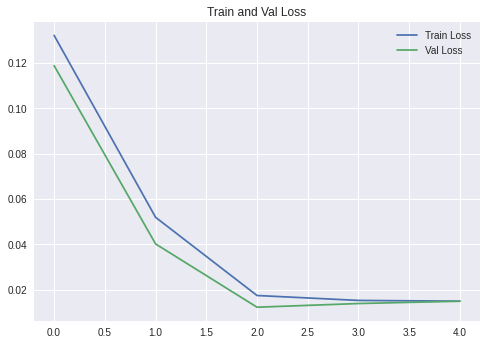

In [92]:
#Parameter
rnn_units =8#rnn神经元个数
save_model='n_lstm_model.h5'#保存模型
#Model
myModel = n_lstm_model()
#train
train_model()#模型训练

###Test and Show

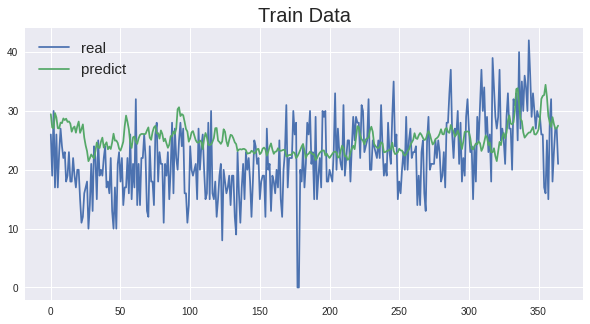

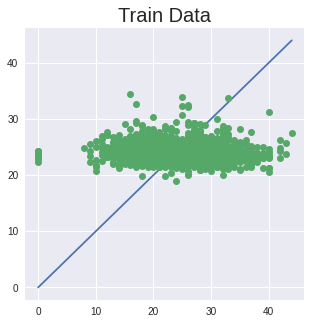

Train上的MAE/RMSE/MAPE
5.232786369455362
6.68675043062185
23.17781361820676


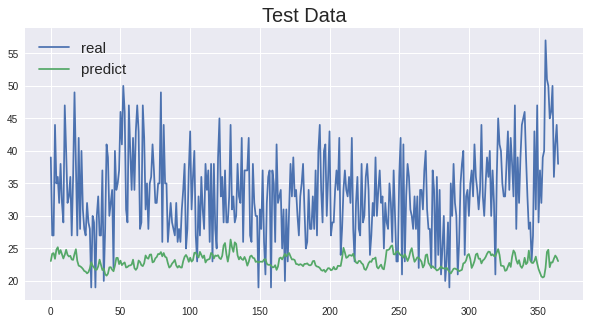

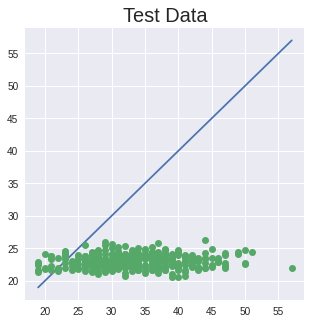

Test上的MAE/RMSE/MAPE
10.594117658432216
12.321475563338975
29.31325292752455


In [93]:
myModel.load_weights(save_model) # 加载最好的训练结果  
y_train_predict=myModel.predict([x0_train,x1_train,x2_train,x3_train,x4_train,x5_train,x6_train])#预测结果
easy_result(y_train,y_train_predict,'Train')#输出评价指标
y_test_predict=myModel.predict([x0_test,x1_test,x2_test,x3_test,x4_test,x5_test,x6_test])#预测结果
easy_result(y_test,y_test_predict,'Test')#输出评价指标

##N_CNN_LSTM

In [94]:
def n_cnn_lstm_model():
  #建立神经网络模型
  inputs0=Input(shape=(delay_factor[0]+1, 1))
  inputs1=Input(shape=(delay_factor[1]+1, 1))
  inputs2=Input(shape=(delay_factor[2]+1, 1))
  inputs3=Input(shape=(delay_factor[3]+1, 1))
  inputs4=Input(shape=(delay_factor[4]+1, 1))
  inputs5=Input(shape=(delay_factor[5]+1, 1))
  inputs6=Input(shape=(1, 4))

  cnn0=Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu')(inputs0)#卷积层
  cnn0=MaxPooling1D(pool_size = window)(cnn0)#池化层
  cnn1=Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu')(inputs1)#卷积层
  cnn1=MaxPooling1D(pool_size = window)(cnn1)#池化层
  cnn2=Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu')(inputs2)#卷积层
  cnn2=MaxPooling1D(pool_size = window)(cnn2)#池化层
  cnn3=Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu')(inputs3)#卷积层
  cnn3=MaxPooling1D(pool_size = window)(cnn3)#池化层
  cnn4=Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu')(inputs4)#卷积层
  cnn4=MaxPooling1D(pool_size = window)(cnn4)#池化层
  cnn5=Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu')(inputs5)#卷积层
  cnn5=MaxPooling1D(pool_size = window)(cnn5)#池化层
  cnn6=Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu')(inputs6)#卷积层
  cnn6=MaxPooling1D(pool_size = window)(cnn6)#池化层 

  rnn0=LSTM(rnn_units, activation='relu',return_sequences=False)(cnn0)
  rnn1=LSTM(rnn_units, activation='relu',return_sequences=False)(cnn1)
  rnn2=LSTM(rnn_units, activation='relu',return_sequences=False)(cnn2)
  rnn3=LSTM(rnn_units, activation='relu',return_sequences=False)(cnn3)
  rnn4=LSTM(rnn_units, activation='relu',return_sequences=False)(cnn4)
  rnn5=LSTM(rnn_units, activation='relu',return_sequences=False)(cnn5)
  rnn6=LSTM(rnn_units, activation='relu',return_sequences=False)(cnn6)

  rnn=Concatenate(axis=1)([rnn0,rnn1,rnn2,rnn3,rnn4,rnn5,rnn6])
  dense=Dropout(dropout)(rnn)#droupout层
  outputs = Dense(1, activation='relu')(dense)
  model = Model(inputs=[inputs0,inputs1,inputs2,inputs3,inputs4,inputs5,inputs6], outputs=outputs)
  model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
  model.summary()#展示模型结构
  return model


###Train

Model: "functional_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_114 (InputLayer)          [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
input_115 (InputLayer)          [(None, 12, 1)]      0                                            
__________________________________________________________________________________________________
input_116 (InputLayer)          [(None, 5, 1)]       0                                            
__________________________________________________________________________________________________
input_117 (InputLayer)          [(None, 2, 1)]       0                                            
______________________________________________________________________________________

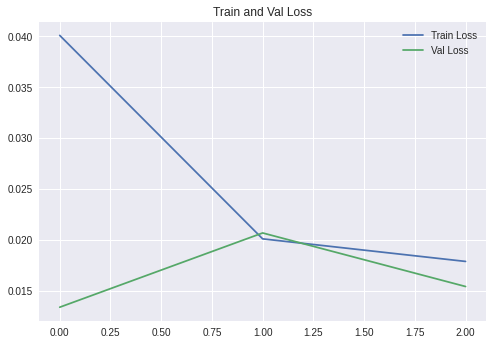

In [95]:
#Parameter
filters=16#cnn filter个数
kernel_size=1#cnn kernel个数
rnn_units =8#rnn神经元个数
save_model='n_cnn_lstm_model.h5'#保存模型
#Model
myModel = n_cnn_lstm_model()
#train
train_model()#模型训练

###Test and Show

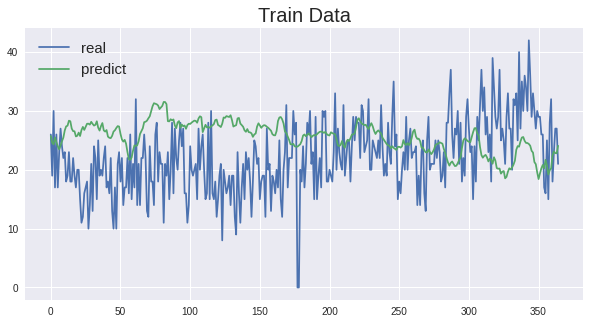

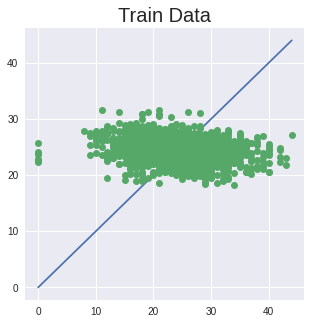

Train上的MAE/RMSE/MAPE
5.780333465670947
7.233304943805015
25.987537471137884


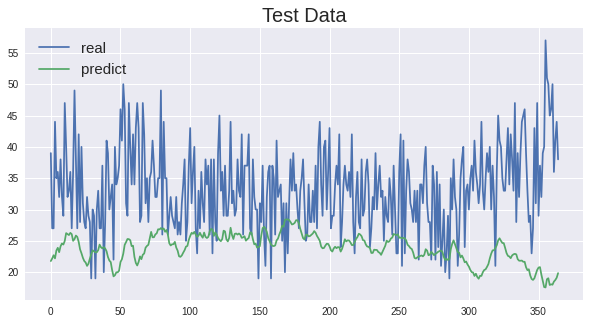

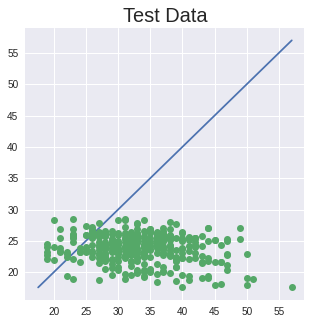

Test上的MAE/RMSE/MAPE
9.998158786721426
12.072168187843685
27.534627057144906


In [96]:
myModel.load_weights(save_model) # 加载最好的训练结果  
y_train_predict=myModel.predict([x0_train,x1_train,x2_train,x3_train,x4_train,x5_train,x6_train])#预测结果
easy_result(y_train,y_train_predict,'Train')#输出评价指标
y_test_predict=myModel.predict([x0_test,x1_test,x2_test,x3_test,x4_test,x5_test,x6_test])#预测结果
easy_result(y_test,y_test_predict,'Test')#输出评价指标

##N_BP

In [97]:
def n_bp_model():
  #建立神经网络模型
  inputs0=Input(shape=(delay_factor[0]+1, 1))
  inputs1=Input(shape=(delay_factor[1]+1, 1))
  inputs2=Input(shape=(delay_factor[2]+1, 1))
  inputs3=Input(shape=(delay_factor[3]+1, 1))
  inputs4=Input(shape=(delay_factor[4]+1, 1))
  inputs5=Input(shape=(delay_factor[5]+1, 1))
  inputs6=Input(shape=(1, 4))

  inputs_bp0=Flatten()(inputs0)
  inputs_bp1=Flatten()(inputs1)
  inputs_bp2=Flatten()(inputs2)
  inputs_bp3=Flatten()(inputs3)
  inputs_bp4=Flatten()(inputs4)
  inputs_bp5=Flatten()(inputs5)
  inputs_bp6=Flatten()(inputs6)

  concat=Concatenate(axis=1)([inputs_bp0,inputs_bp1,inputs_bp2,inputs_bp3,inputs_bp4,inputs_bp5,inputs_bp6])  
  dense=Dense(dense_units,activation='relu')(concat)#全连接层

  dense=Dropout(dropout)(dense)#droupout层
  outputs = Dense(1, activation='relu')(dense)
  model = Model(inputs=[inputs0,inputs1,inputs2,inputs3,inputs4,inputs5,inputs6], outputs=outputs)
  model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
  model.summary()#展示模型结构
  return model


###Train

Model: "functional_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_121 (InputLayer)          [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
input_122 (InputLayer)          [(None, 12, 1)]      0                                            
__________________________________________________________________________________________________
input_123 (InputLayer)          [(None, 5, 1)]       0                                            
__________________________________________________________________________________________________
input_124 (InputLayer)          [(None, 2, 1)]       0                                            
______________________________________________________________________________________

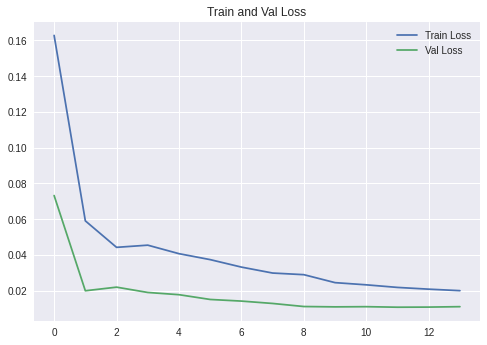

In [98]:
#Parameter
dense_units=32#dense层神经元个数
save_model='n_bp_model.h5'#保存模型
#Model
myModel = n_bp_model()
#train
train_model()#模型训练

###Test and Show

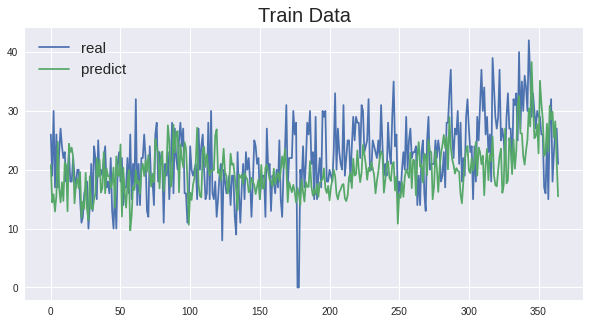

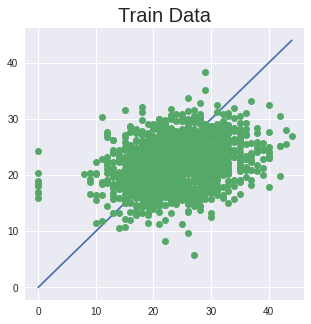

Train上的MAE/RMSE/MAPE
5.238695813344214
6.679721551492362
21.779809767762472


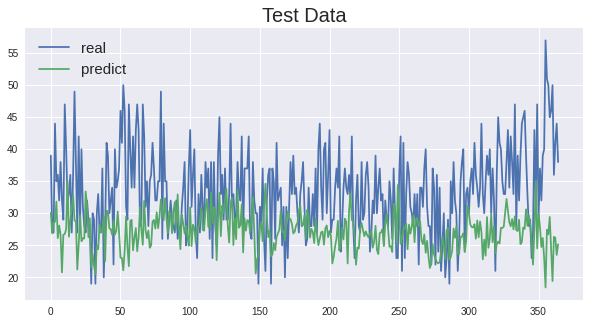

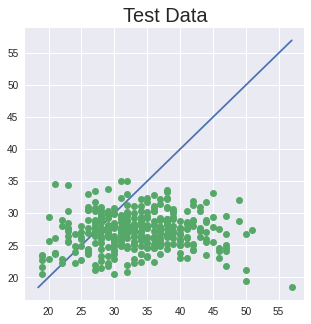

Test上的MAE/RMSE/MAPE
7.386183453912604
9.432047266502597
20.37487982519227


In [99]:
myModel.load_weights(save_model) # 加载最好的训练结果  
y_train_predict=myModel.predict([x0_train,x1_train,x2_train,x3_train,x4_train,x5_train,x6_train])#预测结果
easy_result(y_train,y_train_predict,'Train')#输出评价指标
y_test_predict=myModel.predict([x0_test,x1_test,x2_test,x3_test,x4_test,x5_test,x6_test])#预测结果
easy_result(y_test,y_test_predict,'Test')#输出评价指标